# **Q3**

In [1]:
import torch
from torchvision import datasets, transforms, models
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

## **Part A**

In [2]:
# Load MobileNetV2 with pretrained weights
mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

print(mobilenet_v2)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=


### **MobileNetV2 Architecture**

MobileNetV2 is a lightweight convolutional neural network designed for mobile and embedded vision tasks. It achieves efficiency by using **depthwise separable convolutions** and **inverted residuals**.

#### **Key Components:**

1. **Features Module:**
   - The `features` module is a sequence of convolutional layers designed to extract high-dimensional features from the input image.
   - It begins with a standard convolution layer (`Conv2dNormActivation`) to expand the feature dimensions, followed by a series of **Inverted Residual Blocks**. These blocks:
     - Use depthwise separable convolutions to reduce computation.
     - Leverage "inverted bottlenecks," which expand the channel dimensions before applying depthwise convolutions and then project them back to a smaller dimension.
   - The final convolution layer increases the feature dimensions to 1280 before passing the features to the classifier.

2. **Classifier Module:**
   - A `Dropout` layer with a probability of 0.2 is used for regularization.
   - A `Linear` layer maps the high-dimensional features (1280-dimensional) to 1000 output classes, which correspond to the ImageNet dataset.

---

### **Layer Details**

1. **Initial Convolution Block:**
   - `Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)`
   - Expands the input dimensions from `3 (RGB channels)` to `32`.
   - Applies ReLU6 activation for non-linearity and a BatchNorm layer for normalization.

2. **Inverted Residual Blocks:**
   - Each block has an input expansion phase, a depthwise convolution phase, and a projection phase.
   - Example:
     ```plaintext
     (1): InvertedResidual(
       (conv): Sequential(
         (0): Conv2dNormActivation (expansion phase)
         (1): Depthwise Conv2dNormActivation (spatial feature extraction)
         (2): Pointwise Conv2d (projection phase)
       )
     )
     ```
   - Groups in the convolution indicate depthwise separability (each channel is processed independently).

3. **Feature Expansion:**
   - At the end of the `features` module, the network expands the channels to 1280 using a `Conv2d(320, 1280, kernel_size=(1, 1))`.

4. **Final Classification Layer:**
   - A `Dropout` is applied to reduce overfitting.
   - A `Linear` layer maps the 1280 features to 1000 output classes.

---

### **Input and Output**

1. **Input:**
   - Expects a tensor of size `[Batch, Channels, Height, Width] = [1, 3, 224, 224]`.
   - Requires normalization with ImageNet statistics:  
     - Mean: `[0.485, 0.456, 0.406]`
     - Std: `[0.229, 0.224, 0.225]`.

2. **Output:**
   - Produces a tensor of shape `[Batch, 1000]`, where each value represents the confidence score for one of the 1000 ImageNet classes.

---


## **Part B**

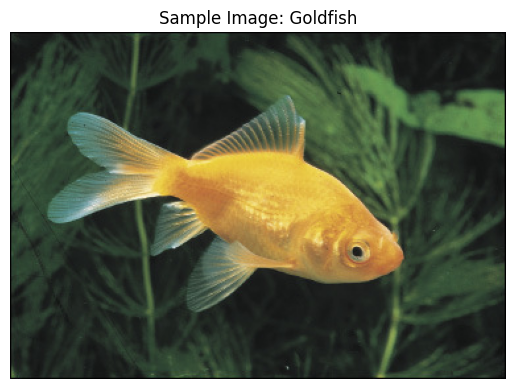

1. goldfish: 98.80%
2. tench: 0.96%
3. axolotl: 0.13%


In [3]:
mobilenet_v2.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load image
image_path = "/content/Goldfish.JPEG"
image = Image.open(image_path)
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Display the image
plt.imshow(image)
plt.axis("off")
plt.title("Sample Image: Goldfish")
plt.show()

# Get predictions
with torch.no_grad():
    output = mobilenet_v2(input_tensor)

# Convert output to probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Load class names
import requests
imagenet_classes = requests.get(
    "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
).json()

# Get top 3 predictions
top3_prob, top3_classes = torch.topk(probabilities, 3)
for i, (idx, prob) in enumerate(zip(top3_classes, top3_prob)):
    print(f"{i + 1}. {imagenet_classes[idx]}: {prob.item() * 100:.2f}%")


## **Part C**

In [4]:
# Load the Flowers102 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = Flowers102(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# Load pretrained MobileNetV2 and modify for 102 classes
mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, 102)  # Replace classifier
mobilenet_v2 = mobilenet_v2.to('cuda' if torch.cuda.is_available() else 'cpu')

# Freeze feature extraction layers
for param in mobilenet_v2.features.parameters():
    param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.classifier.parameters(), lr=0.001)

# Train
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mobilenet_v2 = mobilenet_v2.to(device)

epochs = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(epochs):
    mobilenet_v2.train()
    running_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = mobilenet_v2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs, 1)
        correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation
    mobilenet_v2.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet_v2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted_val = torch.max(outputs, 1)
            correct_val += (predicted_val == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1] * 100:.2f}% - "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1] * 100:.2f}%")

Epoch 1/10 - Train Loss: 4.4169, Train Accuracy: 10.78% - Val Loss: 3.3162, Val Accuracy: 37.75%
Epoch 2/10 - Train Loss: 2.4572, Train Accuracy: 63.92% - Val Loss: 2.1877, Val Accuracy: 67.25%
Epoch 3/10 - Train Loss: 1.4073, Train Accuracy: 88.63% - Val Loss: 1.5440, Val Accuracy: 77.65%
Epoch 4/10 - Train Loss: 0.8732, Train Accuracy: 94.31% - Val Loss: 1.2602, Val Accuracy: 80.69%
Epoch 5/10 - Train Loss: 0.5810, Train Accuracy: 97.65% - Val Loss: 1.0633, Val Accuracy: 83.14%
Epoch 6/10 - Train Loss: 0.4373, Train Accuracy: 97.35% - Val Loss: 0.9548, Val Accuracy: 83.92%
Epoch 7/10 - Train Loss: 0.3131, Train Accuracy: 99.22% - Val Loss: 0.8674, Val Accuracy: 84.02%
Epoch 8/10 - Train Loss: 0.2403, Train Accuracy: 99.71% - Val Loss: 0.8196, Val Accuracy: 85.49%
Epoch 9/10 - Train Loss: 0.1973, Train Accuracy: 99.90% - Val Loss: 0.7827, Val Accuracy: 85.88%
Epoch 10/10 - Train Loss: 0.1567, Train Accuracy: 100.00% - Val Loss: 0.7354, Val Accuracy: 85.88%


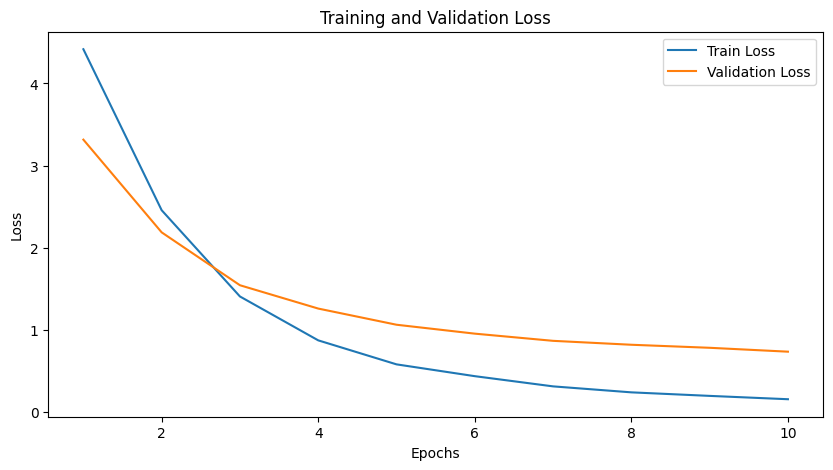

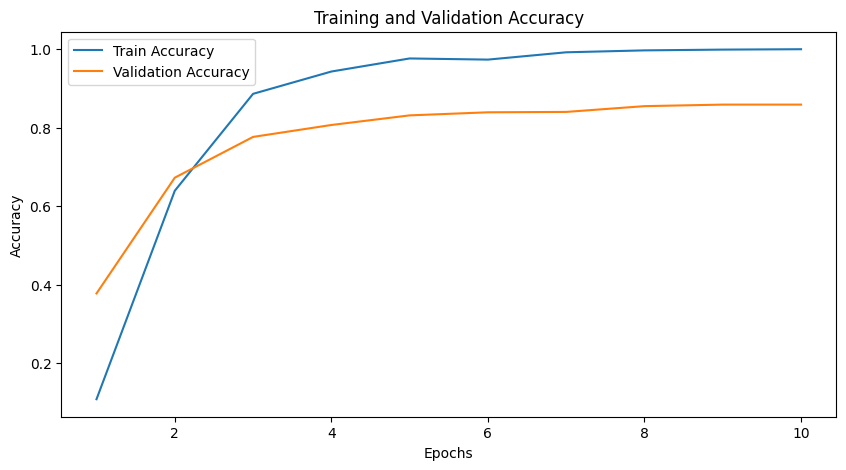

In [6]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [7]:
# Test on test data
mobilenet_v2.eval()
test_correct = 0
test_total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
test_loss = test_loss / len(test_loader)
print("Teat on Test Data")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Loss: {test_loss}")


Teat on Test Data
Accuracy: 84.71%
Loss: 0.8164323209905563


In [8]:
# Test on train data
mobilenet_v2.eval()
test_correct = 0
test_total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy_on_train = test_correct / test_total
test_loss = test_loss / len(train_loader)
print("Test on Train Data")
print(f"Accuracy: {test_accuracy_on_train * 100:.2f}%")
print(f"Loss: {test_loss}")

Test on Train Data
Accuracy: 100.00%
Loss: 0.08154564420692623


In [9]:
# Test on val data
mobilenet_v2.eval()
test_correct = 0
test_total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy_on_val = test_correct / test_total
test_loss = test_loss / len(val_loader)
print("Test on Validation Data")
print(f"Accuracy: {test_accuracy_on_val * 100:.2f}%")
print(f"Loss: {test_loss}")

Test on Validation Data
Accuracy: 85.88%
Loss: 0.7354241693392396


## **Part D**

In [10]:
# Helper function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
results = {}

In [12]:
mobilenet_v2_trainable_params = count_parameters(mobilenet_v2)

# Store MobileNetV2 results (precomputed)
results["MobileNetV2"] = {
    "trainable_params": mobilenet_v2_trainable_params,  # Computed trainable parameters
    "test_accuracy": test_accuracy * 100,
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
}

print(f"Trainable Parameters of MobileNetV2: {mobilenet_v2_trainable_params}")

Trainable Parameters of MobileNetV2: 130662


In [13]:
# Function to train and evaluate a model
def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                correct_val += (predicted_val == labels).sum().item()
                total_val += labels.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1] * 100:.2f}% - "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1] * 100:.2f}%")

    # Test Accuracy
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_test = torch.max(outputs, 1)
            correct_test += (predicted_test == labels).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    return train_losses, train_accuracies, val_losses, val_accuracies, test_accuracy


In [14]:
# Training ResNet50
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 102)  # Modify classifier for 102 classes
resnet50 = resnet50.to(device)

# Freeze feature extraction layers
for param in resnet50.parameters():
    param.requires_grad = False
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Count trainable parameters
resnet50_trainable_params = count_parameters(resnet50)
print(f"Trainable Parameters of ResNet50: {resnet50_trainable_params}")

resnet50_optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Train and evaluate ResNet50
print("Training ResNet50...")
resnet50_train_losses, resnet50_train_accuracies, resnet50_val_losses, resnet50_val_accuracies, resnet50_test_accuracy = train_and_evaluate(
    resnet50, train_loader, val_loader, test_loader, resnet50_optimizer
)

# Store ResNet50 results
results["ResNet50"] = {
    "trainable_params": resnet50_trainable_params,
    "test_accuracy": resnet50_test_accuracy * 100,
    "train_losses": resnet50_train_losses,
    "train_accuracies": resnet50_train_accuracies,
    "val_losses": resnet50_val_losses,
    "val_accuracies": resnet50_val_accuracies
}


Trainable Parameters of ResNet50: 208998
Training ResNet50...
Epoch 1/10 - Train Loss: 4.6275, Train Accuracy: 7.75% - Val Loss: 3.4195, Val Accuracy: 32.55%
Epoch 2/10 - Train Loss: 2.6945, Train Accuracy: 54.12% - Val Loss: 2.3358, Val Accuracy: 59.80%
Epoch 3/10 - Train Loss: 1.6104, Train Accuracy: 79.80% - Val Loss: 1.7109, Val Accuracy: 70.39%
Epoch 4/10 - Train Loss: 0.9914, Train Accuracy: 91.86% - Val Loss: 1.4093, Val Accuracy: 75.49%
Epoch 5/10 - Train Loss: 0.6943, Train Accuracy: 95.39% - Val Loss: 1.1801, Val Accuracy: 79.22%
Epoch 6/10 - Train Loss: 0.4732, Train Accuracy: 96.96% - Val Loss: 1.0413, Val Accuracy: 81.76%
Epoch 7/10 - Train Loss: 0.3755, Train Accuracy: 98.63% - Val Loss: 0.9413, Val Accuracy: 82.35%
Epoch 8/10 - Train Loss: 0.2744, Train Accuracy: 99.31% - Val Loss: 0.8593, Val Accuracy: 85.10%
Epoch 9/10 - Train Loss: 0.2222, Train Accuracy: 99.41% - Val Loss: 0.8218, Val Accuracy: 84.41%
Epoch 10/10 - Train Loss: 0.1742, Train Accuracy: 99.90% - Val Los

In [15]:
# Training VGG16
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 102)  # Modify classifier for 102 classes
vgg16 = vgg16.to(device)

# Freeze feature extraction layers
for param in vgg16.parameters():
    param.requires_grad = False
for param in vgg16.classifier[6].parameters():
    param.requires_grad = True

# Count trainable parameters
vgg16_trainable_params = count_parameters(vgg16)
print(f"Trainable Parameters of VGG16: {vgg16_trainable_params}")

# Define optimizer
vgg16_optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

# Train and evaluate VGG16
print("Training VGG16...")
vgg16_train_losses, vgg16_train_accuracies, vgg16_val_losses, vgg16_val_accuracies, vgg16_test_accuracy = train_and_evaluate(
    vgg16, train_loader, val_loader, test_loader, vgg16_optimizer
)

# Store VGG16 results
results["VGG16"] = {
    "trainable_params": vgg16_trainable_params,
    "test_accuracy": vgg16_test_accuracy * 100,
    "train_losses": vgg16_train_losses,
    "train_accuracies": vgg16_train_accuracies,
    "val_losses": vgg16_val_losses,
    "val_accuracies": vgg16_val_accuracies
}


Trainable Parameters of VGG16: 417894
Training VGG16...
Epoch 1/10 - Train Loss: 3.9080, Train Accuracy: 16.96% - Val Loss: 2.2772, Val Accuracy: 55.39%
Epoch 2/10 - Train Loss: 1.3594, Train Accuracy: 74.02% - Val Loss: 1.5015, Val Accuracy: 68.33%
Epoch 3/10 - Train Loss: 0.7773, Train Accuracy: 86.18% - Val Loss: 1.2813, Val Accuracy: 70.39%
Epoch 4/10 - Train Loss: 0.5518, Train Accuracy: 90.88% - Val Loss: 1.1701, Val Accuracy: 70.98%
Epoch 5/10 - Train Loss: 0.3855, Train Accuracy: 93.53% - Val Loss: 1.1012, Val Accuracy: 73.43%
Epoch 6/10 - Train Loss: 0.2961, Train Accuracy: 95.78% - Val Loss: 1.0544, Val Accuracy: 74.51%
Epoch 7/10 - Train Loss: 0.2420, Train Accuracy: 97.25% - Val Loss: 1.0373, Val Accuracy: 73.63%
Epoch 8/10 - Train Loss: 0.1907, Train Accuracy: 98.04% - Val Loss: 1.0100, Val Accuracy: 73.82%
Epoch 9/10 - Train Loss: 0.1630, Train Accuracy: 98.04% - Val Loss: 0.9930, Val Accuracy: 75.20%
Epoch 10/10 - Train Loss: 0.1563, Train Accuracy: 98.63% - Val Loss: 0.


Final Comparison of Models:
Model: MobileNetV2
Trainable Parameters: 130662
Test Accuracy: 84.71%

Model: ResNet50
Trainable Parameters: 208998
Test Accuracy: 82.50%

Model: VGG16
Trainable Parameters: 417894
Test Accuracy: 73.54%



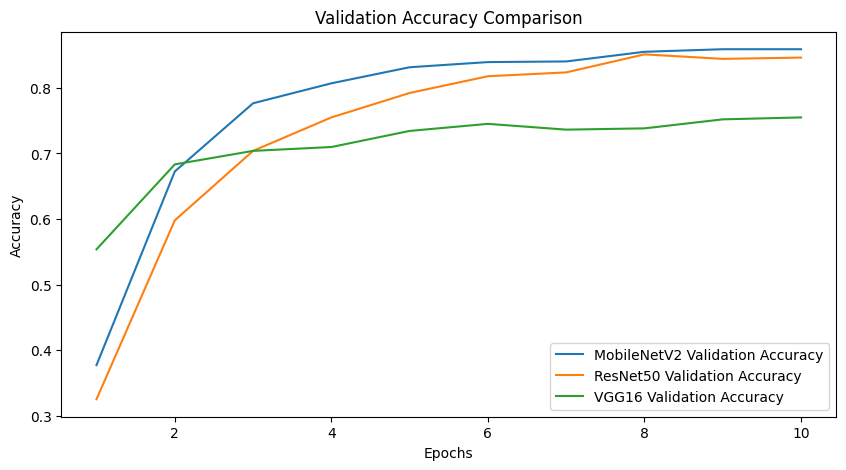

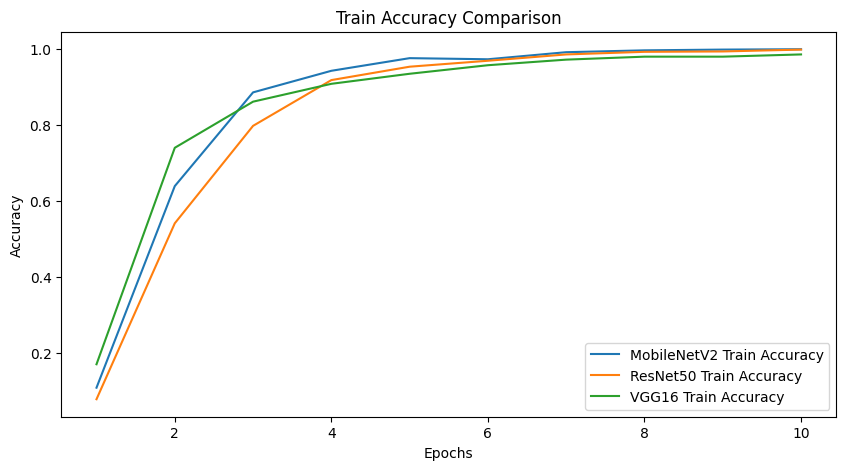

In [16]:
# Final Comparison
print("\nFinal Comparison of Models:")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Trainable Parameters: {metrics['trainable_params']}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.2f}%")
    print()

# Comparison Plot for Accuracy
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(range(1, epochs + 1), metrics["val_accuracies"], label=f"{model_name} Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

# Comparison Plot for Train Accuracy
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(range(1, epochs + 1), metrics["train_accuracies"], label=f"{model_name} Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Comparison")
plt.legend()
plt.show()

### Comparative Analysis

#### **Trainable Parameters:**
- **MobileNetV2:** 130,662 (smallest).
- **ResNet50:** 208,998.
- **VGG16:** 417,894 (largest).

MobileNetV2 achieves the highest efficiency with a lightweight architecture that significantly reduces the number of trainable parameters. In contrast, VGG16 is over three times larger than ResNet50 and over six times larger than MobileNetV2, making it computationally expensive without corresponding performance gains.

---

#### **Test Accuracy:**
- **MobileNetV2:** **84.71%** (highest).
- **ResNet50:** **82.5%**.
- **VGG16:** **73.54%** (lowest).

MobileNetV2's compact design with **depthwise separable convolutions** enables it to maximize feature extraction while minimizing computation, making it highly effective for transfer learning. ResNet50, with its **residual connections**, also performs well but slightly underperforms MobileNetV2. VGG16 struggles with test accuracy, reflecting the limitations of its older architecture, which lacks optimizations like residual learning or separable convolutions.

---

#### **Validation Accuracy Trends:**

1. **MobileNetV2**:
   - Achieves the **fastest convergence** and stabilizes at the highest validation accuracy.
   - Its efficient architecture quickly adapts to the dataset, extracting meaningful features without overfitting.

2. **ResNet50**:
   - Slower initial convergence compared to MobileNetV2 but shows consistent improvement over epochs.
   - Performs competitively but slightly lags behind MobileNetV2 due to higher computational cost and potentially excessive capacity for this dataset.

3. **VGG16**:
   - Peaks early and struggles to improve validation accuracy significantly.
   - Likely overfits to the training data due to its large size and lack of advanced architectural innovations, resulting in subpar generalization.

---

#### **Training Accuracy Trends:**
- All models achieve nearly perfect training accuracy (~100%) by the end of the 10 epochs.

This shows that all models have sufficient capacity to learn the training data. However, the **validation accuracy gaps** highlight the differences in their generalization ability. MobileNetV2 and ResNet50 maintain better generalization, while VGG16's high training accuracy does not translate to strong validation performance.

---

#### **Reasons Behind Performance Differences:**

1. **MobileNetV2**:
   - Incorporates **depthwise separable convolutions**, drastically reducing parameter count while retaining performance.
   - Optimized for transfer learning and efficient feature extraction, making it the best-performing model in terms of both accuracy and computational cost.

2. **ResNet50**:
   - Uses **residual connections** to combat the vanishing gradient problem and facilitate deeper architectures.
   - Offers a balanced trade-off between model size and performance, but its larger size compared to MobileNetV2 slightly reduces its efficiency.

3. **VGG16**:
   - Relies on stacked convolutional layers, which increase computational cost without leveraging modern techniques like separable convolutions or skip connections.
   - Struggles with generalization due to overfitting and inefficiencies in handling diverse datasets like Oxford 102 Flowers.

---

#### **Practical Implications:**

1. **MobileNetV2**:
   - Best suited for real-world applications where both high accuracy and low computational cost are essential.
   - Ideal for deployment on mobile and edge devices.

2. **ResNet50**:
   - Suitable for tasks requiring higher capacity and computational resources.
   - A good choice when moderate hardware is available, and slightly better generalization is required than VGG16.

3. **VGG16**:
   - Outdated for modern tasks, especially those requiring efficient learning and inference.
   - Not recommended for deployment due to its inefficiency and poor performance relative to other models.

---

#### **Summary of Results:**

| **Model**       | **Trainable Parameters** | **Test Accuracy** | **Key Strengths**          | **Key Weaknesses**            |
|------------------|--------------------------|-------------------|----------------------------|--------------------------------|
| **MobileNetV2**  | 130,662                  | **84.71%**        | High efficiency, fast convergence, and excellent generalization. | None notable.                 |
| **ResNet50**     | 208,998                  | 82.5%            | Residual connections improve learning and generalization.        | Higher computational cost.     |
| **VGG16**        | 417,894                  | 73.54%            | Simple and intuitive architecture.                               | Poor generalization; large size.|

---

#### **Final Recommendation:**
- Use **MobileNetV2** for applications requiring high accuracy and efficiency.
- Consider **ResNet50** if computational resources are available and you need slightly higher model capacity.
- Avoid **VGG16** for this task due to its inefficiency and inferior performance.


## **Part E**

In [17]:
# Training and evaluation
def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

            # if batch_idx % 10 == 0 or batch_idx == len(train_loader):
            #     print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {running_loss / batch_idx:.4f}, Accuracy: {correct_train / total_train * 100:.2f}%")

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader, 1):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                correct_val += (predicted_val == labels).sum().item()
                total_val += labels.size(0)

                # # Print batch progress
                # if batch_idx % 10 == 0 or batch_idx == len(val_loader):
                #     print(f"  Batch {batch_idx}/{len(val_loader)} - Loss: {val_loss / batch_idx:.4f}, Accuracy: {correct_val / total_val * 100:.2f}%")

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1] * 100:.2f}% - "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1] * 100:.2f}%")

    # Test Accuracy
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_test = torch.max(outputs, 1)
            correct_test += (predicted_test == labels).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    return train_losses, train_accuracies, val_losses, val_accuracies, test_accuracy


In [18]:
# MobileNetV2 from scratch
mobilenet_v2_scratch = models.mobilenet_v2(weights=None)  # No pretrained weights
mobilenet_v2_scratch.classifier[1] = nn.Linear(mobilenet_v2_scratch.last_channel, 102)
mobilenet_v2_scratch = mobilenet_v2_scratch.to(device)

# optimizer
optimizer_scratch = optim.Adam(mobilenet_v2_scratch.parameters(), lr=0.001)

# Train and evaluate
print("Training MobileNetV2 from scratch...")
mobilenet_v2_scratch_train_losses, mobilenet_v2_scratch_train_accuracies, \
mobilenet_v2_scratch_val_losses, mobilenet_v2_scratch_val_accuracies, \
mobilenet_v2_scratch_test_accuracy = train_and_evaluate(
    mobilenet_v2_scratch, train_loader, val_loader, test_loader, optimizer_scratch
)

# Store results for comparison
results["MobileNetV2_from_scratch"] = {
    "trainable_params": count_parameters(mobilenet_v2_scratch),
    "test_accuracy": mobilenet_v2_scratch_test_accuracy * 100,
    "train_losses": mobilenet_v2_scratch_train_losses,
    "train_accuracies": mobilenet_v2_scratch_train_accuracies,
    "val_losses": mobilenet_v2_scratch_val_losses,
    "val_accuracies": mobilenet_v2_scratch_val_accuracies
}


Training MobileNetV2 from scratch...
Epoch 1/10 - Train Loss: 4.8421, Train Accuracy: 0.98% - Val Loss: 4.9646, Val Accuracy: 0.98%
Epoch 2/10 - Train Loss: 4.2523, Train Accuracy: 4.02% - Val Loss: 6.2958, Val Accuracy: 0.98%
Epoch 3/10 - Train Loss: 3.9256, Train Accuracy: 5.88% - Val Loss: 4.3992, Val Accuracy: 7.75%
Epoch 4/10 - Train Loss: 3.6137, Train Accuracy: 9.51% - Val Loss: 4.0257, Val Accuracy: 8.53%
Epoch 5/10 - Train Loss: 3.4057, Train Accuracy: 10.98% - Val Loss: 4.2480, Val Accuracy: 6.57%
Epoch 6/10 - Train Loss: 3.2152, Train Accuracy: 15.98% - Val Loss: 4.0073, Val Accuracy: 11.08%
Epoch 7/10 - Train Loss: 2.9645, Train Accuracy: 18.53% - Val Loss: 4.4855, Val Accuracy: 11.67%
Epoch 8/10 - Train Loss: 2.8226, Train Accuracy: 23.53% - Val Loss: 3.7548, Val Accuracy: 15.49%
Epoch 9/10 - Train Loss: 2.6885, Train Accuracy: 25.59% - Val Loss: 4.3077, Val Accuracy: 11.27%
Epoch 10/10 - Train Loss: 2.6550, Train Accuracy: 24.31% - Val Loss: 4.6579, Val Accuracy: 11.76%
T

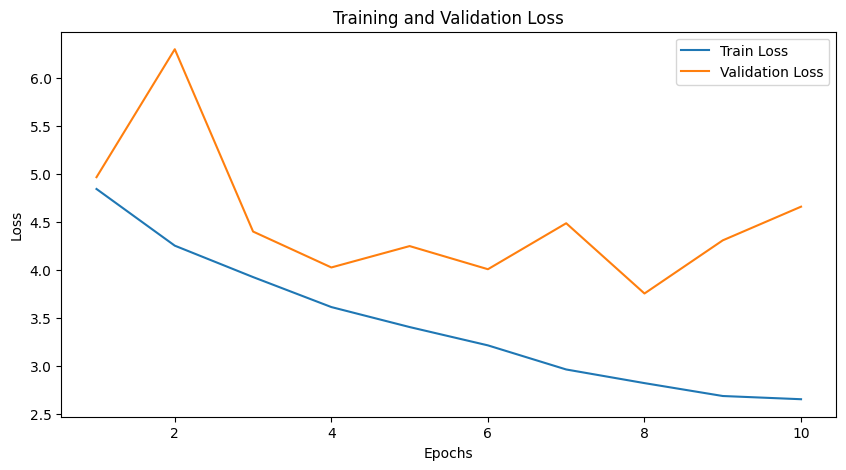

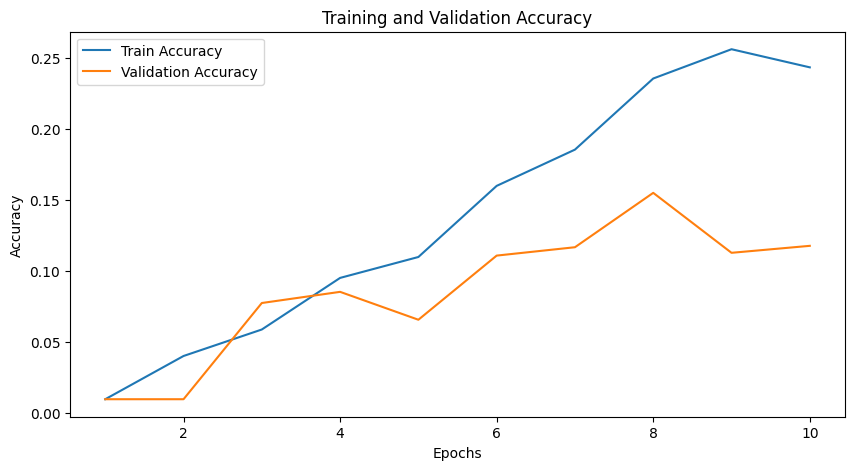

In [19]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mobilenet_v2_scratch_train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), mobilenet_v2_scratch_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mobilenet_v2_scratch_train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), mobilenet_v2_scratch_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Comparison of MobileNetV2 with and without Transfer Learning:
Model: MobileNetV2 (Transfer Learning)
Trainable Parameters: 130662
Test Accuracy: 84.71%

Model: MobileNetV2 (From Scratch)
Trainable Parameters: 2354534
Test Accuracy: 9.20%


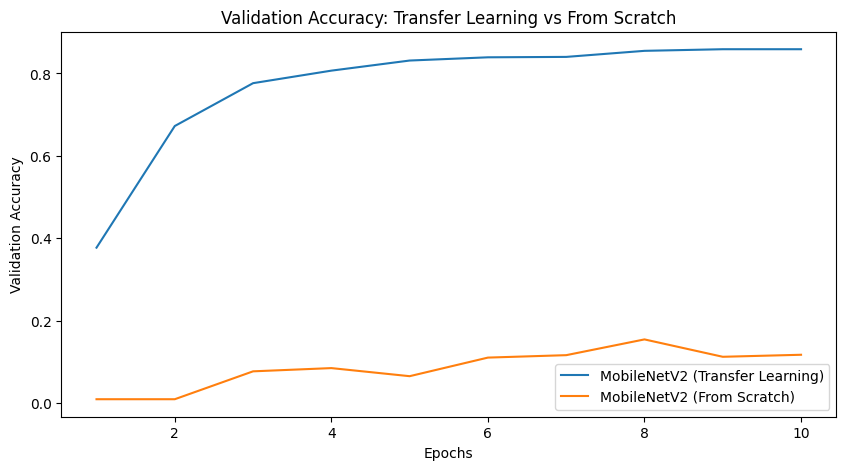

In [20]:
# Final Comparison
print("\nComparison of MobileNetV2 with and without Transfer Learning:")
print(f"Model: MobileNetV2 (Transfer Learning)")
print(f"Trainable Parameters: {results['MobileNetV2']['trainable_params']}")
print(f"Test Accuracy: {results['MobileNetV2']['test_accuracy']:.2f}%")
print()
print(f"Model: MobileNetV2 (From Scratch)")
print(f"Trainable Parameters: {results['MobileNetV2_from_scratch']['trainable_params']}")
print(f"Test Accuracy: {results['MobileNetV2_from_scratch']['test_accuracy']:.2f}%")

# Comparison Plot for Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), results["MobileNetV2"]["val_accuracies"], label="MobileNetV2 (Transfer Learning)")
plt.plot(range(1, epochs + 1), results["MobileNetV2_from_scratch"]["val_accuracies"], label="MobileNetV2 (From Scratch)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy: Transfer Learning vs From Scratch")
plt.legend()
plt.show()


In [24]:
# Test on test data
mobilenet_v2_scratch.eval()
test_correct = 0
test_total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2_scratch(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
test_loss = test_loss / len(test_loader)
print("Test on Validation Data")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Loss: {test_loss}")


Test on Validation Data
Accuracy: 9.20%
Loss: 4.883271017222825


In [25]:
# Test on train data
mobilenet_v2_scratch.eval()
test_correct = 0
test_total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2_scratch(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
test_loss = test_loss / len(train_loader)
print("Test on Train Data")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Loss: {test_loss}")

Test on Train Data
Accuracy: 22.06%
Loss: 3.1574086099863052


In [26]:
# Test on val data
mobilenet_v2_scratch.eval()
test_correct = 0
test_total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2_scratch(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
test_loss = test_loss / len(val_loader)
print("Test on Validation Data")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Loss: {test_loss}")

Test on Validation Data
Accuracy: 11.76%
Loss: 4.6579418778419495


### Analysis of MobileNetV2 with and without Transfer Learning

---

#### **Key Metrics:**
1. **Transfer Learning (Pretrained Weights):**
   - **Trainable Parameters:** 130,662
   - **Test Accuracy:** **84.71%**

2. **From Scratch (Random Initialization):**
   - **Trainable Parameters:** 2,354,534
   - **Test Accuracy:** **9.2%**

---

#### **Validation Accuracy Comparison:**
1. **Transfer Learning:**
   - Shows rapid improvement in validation accuracy, converging to over **84%** by the end of training.
   - Achieves strong performance within the first few epochs, leveraging pretrained features from ImageNet.

2. **From Scratch:**
   - Struggles to improve validation accuracy, peaking at only **9.2%** after 10 epochs.
   - Demonstrates a near-flat trend, suggesting the model is unable to generalize effectively from random initialization with limited training data.

---

#### **Reasons for the Performance Gap:**

1. **Transfer Learning:**
   - **Pretrained Weights:** The network starts with feature representations learned from the massive ImageNet dataset, providing a strong foundation for recognizing patterns and features in the Oxford 102 Flower dataset.
   - **Efficient Fine-Tuning:** Only the classification layers are trained, minimizing overfitting and computational cost.
   - **Small Trainable Parameters:** With only 130,662 trainable parameters, the model adapts efficiently to the new dataset without requiring extensive training.

2. **From Scratch:**
   - **Lack of Pretrained Features:** The network starts with random weights, requiring it to learn both low-level and high-level features from scratch, which is highly challenging given the relatively small Oxford 102 Flower dataset.
   - **Large Number of Parameters:** With 2,354,534 trainable parameters, the model becomes prone to overfitting and struggles to converge effectively due to insufficient data and computational complexity.
   - **Inefficient Learning:** Without pretrained weights, the model requires significantly more epochs and potentially a larger dataset to learn meaningful features.

---

#### **Practical Implications:**
1. **Efficiency of Transfer Learning:**
   - The results demonstrate the power of transfer learning, where pretrained weights drastically improve performance with minimal computational effort.
   - Transfer learning is particularly effective for tasks with limited data, as it reduces the risk of overfitting.

2. **Challenges of Training From Scratch:**
   - Training deep models like MobileNetV2 from scratch is impractical for small or medium-sized datasets without significant computational resources or advanced regularization techniques.
   - The high trainable parameter count and lack of pretrained features result in poor generalization and low validation accuracy.

---
